In [1]:
import os
import gc
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import glob
import heartpy as hp
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from imblearn.under_sampling import RandomUnderSampler

from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
from scipy.signal import butter, lfilter
from scipy.io import loadmat
from scipy.stats import skew, kurtosis

In [2]:
TIMESTEP = 5000
EPOCHS = 70
LR = 1e-3
BS = 32
SEED = 42
MODEL_NAME ='Conv1d_ver_7'
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(SEED) # Seed 고정

In [3]:
device = torch.device("mps" if  torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [4]:
adult_data_num = len(os.listdir('./ECG_adult_numpy_train'))
child_data_num = len(os.listdir('./ECG_child_numpy_train'))

In [5]:
train_adult_csv = pd.read_csv('./ECG_adult_age_train.csv')
train_child_csv = pd.read_csv('./ECG_child_age_train.csv')
train_adult_csv

,FILENAME,GENDER,AGE
0,ecg_adult_0,MALE,53
1,ecg_adult_1,MALE,68
2,ecg_adult_2,MALE,68
3,ecg_adult_3,MALE,89
4,ecg_adult_4,MALE,79
...,...,...,...
34902,ecg_adult_35136,MALE,19
34903,ecg_adult_35137,FEMALE,63
34904,ecg_adult_35138,MALE,60
34905,ecg_adult_35139,FEMALE,60


In [6]:
train_adult_csv.loc[train_adult_csv['GENDER'] == 'MALE',  'GENDER'] = 0
train_adult_csv.loc[train_adult_csv['GENDER'] == 'FEMALE',  'GENDER'] = 1
train_adult_csv.loc[train_adult_csv['GENDER'] == 'unknown',  'GENDER'] = 0
train_child_csv.loc[train_child_csv['GENDER'] == 'MALE',  'GENDER'] = 0
train_child_csv.loc[train_child_csv['GENDER'] == 'FEMALE',  'GENDER'] = 1
train_child_csv.loc[train_child_csv['GENDER'] == 'unknown',  'GENDER'] = 0

In [7]:
train_adult_age = np.array(train_adult_csv['AGE'])
train_child_age = np.array(train_child_csv['AGE'])
print(train_adult_age.shape)

(34907,)


(array([2.159e+03, 2.462e+03, 3.486e+03, 6.247e+03, 9.501e+03, 8.003e+03,
        2.921e+03, 1.230e+02, 1.000e+00, 4.000e+00]),
 array([ 19. ,  29.3,  39.6,  49.9,  60.2,  70.5,  80.8,  91.1, 101.4,
        111.7, 122. ]),
 <BarContainer object of 10 artists>)

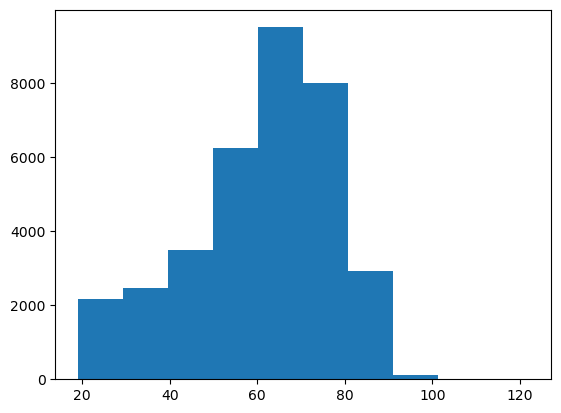

In [8]:
plt.hist(train_adult_age)

In [9]:
train_adult_path = [f'./ECG_adult_numpy_train/{name}.npy' for name in train_adult_csv['FILENAME']]
train_child_path = [f'./ECG_child_numpy_train/{name}.npy' for name in train_child_csv['FILENAME']]
train_adult_path

['./ECG_adult_numpy_train/ecg_adult_0.npy',
 './ECG_adult_numpy_train/ecg_adult_1.npy',
 './ECG_adult_numpy_train/ecg_adult_2.npy',
 './ECG_adult_numpy_train/ecg_adult_3.npy',
 './ECG_adult_numpy_train/ecg_adult_4.npy',
 './ECG_adult_numpy_train/ecg_adult_5.npy',
 './ECG_adult_numpy_train/ecg_adult_6.npy',
 './ECG_adult_numpy_train/ecg_adult_7.npy',
 './ECG_adult_numpy_train/ecg_adult_8.npy',
 './ECG_adult_numpy_train/ecg_adult_9.npy',
 './ECG_adult_numpy_train/ecg_adult_10.npy',
 './ECG_adult_numpy_train/ecg_adult_11.npy',
 './ECG_adult_numpy_train/ecg_adult_12.npy',
 './ECG_adult_numpy_train/ecg_adult_13.npy',
 './ECG_adult_numpy_train/ecg_adult_14.npy',
 './ECG_adult_numpy_train/ecg_adult_15.npy',
 './ECG_adult_numpy_train/ecg_adult_16.npy',
 './ECG_adult_numpy_train/ecg_adult_17.npy',
 './ECG_adult_numpy_train/ecg_adult_19.npy',
 './ECG_adult_numpy_train/ecg_adult_20.npy',
 './ECG_adult_numpy_train/ecg_adult_21.npy',
 './ECG_adult_numpy_train/ecg_adult_22.npy',
 './ECG_adult_numpy_

In [10]:
adult_np = []
adult_sex = []

for i, path in tqdm(enumerate(train_adult_path)):
    adult_np_tmp = np.load(path).reshape(5000,-1)
    adult_sex_tmp = int(train_adult_csv['GENDER'][i])
    adult_np.append(adult_np_tmp)
    adult_sex.append(adult_sex_tmp)
    
adult_np = np.array(adult_np)
adult_sex = np.array(adult_sex)
adult_np.shape

0it [00:00, ?it/s]

(34907, 5000, 12)

In [11]:
child_np = []
child_sex = []

for i,path in tqdm(enumerate(train_child_path)):
    child_np_tmp = np.load(path).reshape(5000,-1)
    child_sex_tmp = train_child_csv['GENDER'][i]
    child_np.append(child_np_tmp)
    child_sex.append(child_sex_tmp)
    
child_np = np.array(child_np)
child_sex = np.array(child_sex)

child_np.shape

0it [00:00, ?it/s]

(8781, 5000, 12)

In [12]:
gc.collect()

450

In [13]:
class MyDataset(Dataset):
    def __init__(self, origin_x, origin_y, sex):
        self.data = origin_x
        self.target = origin_y
        self.sex = sex
    def __getitem__(self, index):
        self.x = self.data[index]
        self.y = self.target[index]
        return self.x, self.y, self.sex[index]

    def __len__(self):
        return len(self.data)

#Pytorch를 사용하기 위해 custom dataset 구성해줌

In [14]:
class TestDataset(Dataset):
    def __init__(self, origin_x, sex):
        self.data = origin_x
        self.sex = sex
    def __getitem__(self, index):
        self.x = self.data[index]
        return self.x, self.sex[index]
    def __len__(self):
        return len(self.data)


In [15]:
#Reference : https://doheon.github.io/%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84/time-series/ci-3.lstm-post/
class Model(nn.Module):
    def __init__(self, input_size):
        super(Model, self).__init__()
        self.input_size = input_size
        print
        self.conv1 = self.return_conv(self.input_size, 16)
        self.conv2 = self.return_conv(16, 32)
        self.conv3 = self.return_conv(32, 64)
        self.conv4 = self.return_conv(64, 128)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.output = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(128+1,1)
        )
            
        
        self.init_weight()
        
    def forward(self, x, sex):
        x = x.transpose(1,2)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.gap(x)
        x = x.transpose(1,2)
        x = x.squeeze(1)
        x = self.output(torch.cat((x, sex.reshape(-1,1)), dim=1))
        return x
    
    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.GroupNorm):
                nn.init.constant(m.weight, 1)
                nn.init.constant(m.bias, 0)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
                
    def return_conv(self, input_s, output_s):
        layer = nn.Sequential(
            nn.Conv1d(in_channels =  input_s, out_channels = output_s, kernel_size = 3, padding='same'),
            nn.ReLU(),
            nn.GroupNorm(1,output_s),
            nn.Conv1d(in_channels =  output_s, out_channels = output_s, kernel_size = 3, padding='same'),
            nn.ReLU(),
            nn.GroupNorm(1,output_s),
            nn.Conv1d(in_channels =  output_s, out_channels = output_s, kernel_size = 3, padding='same'),
            nn.ReLU(),
            nn.GroupNorm(1,output_s),
            nn.AvgPool1d(2)
        )
        return layer
            

In [16]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device, fold, name):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        self.fold = fold
        self.name = name
        # Loss Function
        self.criterion = nn.L1Loss().to(device)
        
    def fit(self, ):
        best_loss = 1000000000
        best_error =100000000
        #가장 적은 loss값 기록
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            i = 1
            for x,y,sex in tqdm(iter(self.train_loader)):
                x = x.float().to(self.device)
                #y = (y.float()+torch.randn_like(y.float())).to(self.device)
                y = y.float().to(self.device)
                sex = sex.float().to(self.device)
                self.optimizer.zero_grad()
                pred = self.model(x, sex).squeeze(1)
                loss = self.criterion(pred, y)
                loss.backward()
                self.optimizer.step()
                train_loss.append(loss.item())
                i=i+1
                #train
                
            mean_train_loss = np.mean(train_loss)
            
            val_loss, true, pred = self.validation(self.model)
            #validation 수행
            val_error = mean_absolute_error(true, pred)

            print(f'Epoch : [{epoch+1}] Train loss : [{mean_train_loss}]\nVal Loss : [{val_loss}]\nVal L1 : [{val_error}]')
            
            self.scheduler.step(val_loss)
            #Scheduler 사용
            
            if best_loss > val_loss:
                best_loss = val_loss
                best_error = val_error
                torch.save(self.model, f'./model/{MODEL_NAME}_{self.name}_{self.fold}.pth')
                print(f"Save Model~_~ MODEL_NAME : {MODEL_NAME}_{self.name}_{self.fold}.pth")
            
        print(f'Final Best error : [{best_error}]')
        print(f'Final Best loss : [{best_loss}]')

    def validation(self, eval_model):
        eval_model.eval()
        val_loss = []
        pred = []
        true = []
        with torch.no_grad():
            for x,y, sex in iter(self.val_loader):
                pred_tmp = []
                x = x.float().to(self.device)
                y = y.float().to(self.device)
                sex = sex.float().to(self.device)
                batch_pred = eval_model(x, sex).squeeze(1)
                loss = self.criterion(batch_pred, y)
                val_loss.append(loss.item())
                true += y.cpu().detach().tolist()
                
                pred += batch_pred.cpu().detach().tolist()
        return np.mean(val_loss), true, pred
    
    

In [17]:
kfold = KFold(n_splits=10)
fold = 0

for train_idx, val_idx in kfold.split(adult_np):
    fold = fold+1
    if fold > 6:
        train_adult_x, val_adult_x = adult_np[train_idx], adult_np[val_idx] 
        train_adult_y, val_adult_y = train_adult_age[train_idx], train_adult_age[val_idx]
        print(train_adult_x.shape)
        print(val_adult_x.shape)
        print(train_adult_y.shape)
        print(val_adult_y.shape)
        
        train_adult_sex, val_adult_sex = adult_sex[train_idx], adult_sex[val_idx]
        print(train_adult_sex.shape)
        print(val_adult_sex.shape)
     
        train_adult_dataset = MyDataset(torch.tensor(train_adult_x),torch.tensor(train_adult_y), torch.tensor(train_adult_sex))
        train_adult_loader = DataLoader(train_adult_dataset, batch_size=BS, shuffle=True)
        val_adult_dataset = MyDataset(torch.tensor(val_adult_x),torch.tensor(val_adult_y), torch.tensor(val_adult_sex))
        val_adult_loader = DataLoader(val_adult_dataset, batch_size=BS, shuffle=False)
    
        
        it = iter(train_adult_loader)
        input_size = next(it)[0].shape[2]
    
        print(f"Adult {fold} fold model training start ~_~")
    
        gc.collect()
        ### ADULT MODEL ###
        seed_everything(SEED)
        model = Model(input_size)
        model = model.to(device)
        print(summary(model))
        
        optimizer = torch.optim.AdamW(params = model.parameters(), lr = LR, weight_decay=1e-2)#Opimizer : AdamW
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold = 1e-8, threshold_mode='abs', min_lr=1e-8, verbose=True)
        trainer = Trainer(model, optimizer, train_adult_loader, val_adult_loader, scheduler, device, fold, 'adult')
        trainer.fit()


    

(31416, 5000, 12)
(3491, 5000, 12)
(31416,)
(3491,)
(31416,)
(3491,)
Adult 7 fold model training start ~_~
Layer (type:depth-idx)                   Param #
Model                                    --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       592
│    └─ReLU: 2-2                         --
│    └─GroupNorm: 2-3                    32
│    └─Conv1d: 2-4                       784
│    └─ReLU: 2-5                         --
│    └─GroupNorm: 2-6                    32
│    └─Conv1d: 2-7                       784
│    └─ReLU: 2-8                         --
│    └─GroupNorm: 2-9                    32
│    └─AvgPool1d: 2-10                   --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-11                      1,568
│    └─ReLU: 2-12                        --
│    └─GroupNorm: 2-13                   64
│    └─Conv1d: 2-14                      3,104
│    └─ReLU: 2-15                        --
│    └─GroupNorm: 2-16                   64

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_19191/326351055.py:38: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.weight, 1)
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_19191/326351055.py:39: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


  0%|          | 0/982 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343685278/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch : [1] Train loss : [16.6746835582368]
Val Loss : [12.795511458136819]
Val L1 : [12.858603426939572]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [2] Train loss : [11.65531589397345]
Val Loss : [10.696130501140248]
Val L1 : [10.669643238191105]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [3] Train loss : [10.329825353719553]
Val Loss : [9.34391166080128]
Val L1 : [9.345113700729016]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [4] Train loss : [9.764879180069125]
Val Loss : [9.252821441130205]
Val L1 : [9.231721100032722]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [5] Train loss : [9.547542021862116]
Val Loss : [8.99849480715665]
Val L1 : [9.010614786882927]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [6] Train loss : [9.33772200479527]
Val Loss : [8.88272064815868]
Val L1 : [8.859212589619052]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [7] Train loss : [9.215124435677305]
Val Loss : [8.88397570956837]
Val L1 : [8.872485663207204]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [8] Train loss : [9.066596313309525]
Val Loss : [8.698188144510443]
Val L1 : [8.683884246135571]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [9] Train loss : [9.029615733871148]
Val Loss : [8.946847135370428]
Val L1 : [8.919115070352852]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [10] Train loss : [8.916832103748671]
Val Loss : [8.373622447794133]
Val L1 : [8.3599601392929]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [11] Train loss : [8.911942852004724]
Val Loss : [8.317873829061336]
Val L1 : [8.297321433496489]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [12] Train loss : [8.78368733225432]
Val Loss : [8.409815359115601]
Val L1 : [8.406870753196207]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [13] Train loss : [8.758953481487733]
Val Loss : [8.365207117254084]
Val L1 : [8.360637482856482]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [14] Train loss : [8.66020480921215]
Val Loss : [8.272300091656772]
Val L1 : [8.27230670451435]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [15] Train loss : [8.619110122960358]
Val Loss : [9.118717445026745]
Val L1 : [9.064396076098584]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [16] Train loss : [8.565324364757343]
Val Loss : [8.21536243612116]
Val L1 : [8.189295640615978]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [17] Train loss : [8.506759277914789]
Val Loss : [8.204031961614435]
Val L1 : [8.170135737353291]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [18] Train loss : [8.462552175988005]
Val Loss : [8.155355873974887]
Val L1 : [8.138047486313159]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [19] Train loss : [8.416956404804456]
Val Loss : [8.402600288391113]
Val L1 : [8.353587447521305]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [20] Train loss : [8.412035716769651]
Val Loss : [8.67377289425243]
Val L1 : [8.622962841841458]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [21] Train loss : [8.363719689141952]
Val Loss : [8.144977530566129]
Val L1 : [8.109414516701394]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [22] Train loss : [8.332043262703113]
Val Loss : [8.004294447465377]
Val L1 : [7.983974790067736]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [23] Train loss : [8.274602832716496]
Val Loss : [8.158439983021129]
Val L1 : [8.155618457799653]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [24] Train loss : [8.231107237868299]
Val Loss : [8.036601166291671]
Val L1 : [8.0264733565021]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [25] Train loss : [8.143760605402246]
Val Loss : [7.989370059967041]
Val L1 : [7.974124204733418]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [26] Train loss : [8.147359112372467]
Val Loss : [8.342072491212324]
Val L1 : [8.301177250215503]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [27] Train loss : [8.111570668074847]
Val Loss : [7.920478118549694]
Val L1 : [7.892851410196218]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [28] Train loss : [8.039383836287831]
Val Loss : [8.03977068120783]
Val L1 : [8.00961058940904]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [29] Train loss : [8.046258193655072]
Val Loss : [8.494786578958685]
Val L1 : [8.456004595968245]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [30] Train loss : [7.989183988687706]
Val Loss : [8.133285245028409]
Val L1 : [8.106423059188682]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [31] Train loss : [7.978225427343986]
Val Loss : [8.051838224584406]
Val L1 : [8.031174953398407]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [32] Train loss : [7.973812462598874]
Val Loss : [7.886009558764371]
Val L1 : [7.882936432313113]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [33] Train loss : [7.898940236650999]
Val Loss : [7.99178018136458]
Val L1 : [7.970470581448068]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [34] Train loss : [7.843473083861248]
Val Loss : [7.896912886879661]
Val L1 : [7.87208908439468]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [35] Train loss : [7.846319198122821]
Val Loss : [8.08076963858171]
Val L1 : [8.030583166386329]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [36] Train loss : [7.830335998729387]
Val Loss : [8.068399650400336]
Val L1 : [8.032420753100922]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [37] Train loss : [7.751359358338863]
Val Loss : [7.829397756403143]
Val L1 : [7.806252141628522]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [38] Train loss : [7.747745465843837]
Val Loss : [8.316400601647118]
Val L1 : [8.345243048579125]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [39] Train loss : [7.762103369668156]
Val Loss : [8.197600720145486]
Val L1 : [8.161544307532811]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [40] Train loss : [7.678906636908195]
Val Loss : [7.884073344143954]
Val L1 : [7.876185436297952]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [41] Train loss : [7.701190031715906]
Val Loss : [7.829989901455966]
Val L1 : [7.810081315293281]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [42] Train loss : [7.6740995463431485]
Val Loss : [7.912126939946955]
Val L1 : [7.902528118656959]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [43] Train loss : [7.637625733121107]
Val Loss : [7.904825795780528]
Val L1 : [7.899394630600408]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [44] Train loss : [7.670591184417973]
Val Loss : [7.8226518630981445]
Val L1 : [7.823500029236906]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [45] Train loss : [7.658011622438606]
Val Loss : [7.950253248214722]
Val L1 : [7.945772296137333]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [46] Train loss : [7.561042657452057]
Val Loss : [7.878511853651567]
Val L1 : [7.886288860608431]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [47] Train loss : [7.521114930601566]
Val Loss : [7.918635272979737]
Val L1 : [7.917547781055617]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [48] Train loss : [7.533569934654624]
Val Loss : [7.852191058072177]
Val L1 : [7.828390493532266]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [49] Train loss : [7.505998374002771]
Val Loss : [7.852336662465876]
Val L1 : [7.819501379641924]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [50] Train loss : [7.432578235439759]
Val Loss : [7.776562014493075]
Val L1 : [7.759339108845458]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [51] Train loss : [7.440089028138979]
Val Loss : [8.05328056162054]
Val L1 : [8.017435186403045]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [52] Train loss : [7.447461899817597]
Val Loss : [7.8901118798689405]
Val L1 : [7.8781740865540755]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [53] Train loss : [7.3851116995219055]
Val Loss : [7.912454292990945]
Val L1 : [7.894838445134027]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [54] Train loss : [7.331480596313166]
Val Loss : [7.807255138050426]
Val L1 : [7.796829088135115]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [55] Train loss : [7.355799564761688]
Val Loss : [7.701153039932251]
Val L1 : [7.6735742744351825]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_7.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [56] Train loss : [7.36717121032979]
Val Loss : [8.378677853670988]
Val L1 : [8.353021489211393]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [57] Train loss : [7.341769630700168]
Val Loss : [8.06455960707231]
Val L1 : [8.06023456701335]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [58] Train loss : [7.286539431744826]
Val Loss : [7.7713044209913775]
Val L1 : [7.779468451690892]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [59] Train loss : [7.294384398916831]
Val Loss : [7.857024578614668]
Val L1 : [7.848070642935174]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [60] Train loss : [7.207686639851805]
Val Loss : [8.078053543784401]
Val L1 : [8.059800836152792]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [61] Train loss : [7.222866659009044]
Val Loss : [7.977511297572743]
Val L1 : [7.943727322274926]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [62] Train loss : [7.194773658958327]
Val Loss : [7.866219520568848]
Val L1 : [7.877412360023885]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [63] Train loss : [7.182182166581241]
Val Loss : [7.745921039581299]
Val L1 : [7.735199799615515]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [64] Train loss : [7.170905710480606]
Val Loss : [8.8978459705006]
Val L1 : [8.939968656038904]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [65] Train loss : [7.14555253225043]
Val Loss : [7.873457553169944]
Val L1 : [7.846035576795514]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [66] Train loss : [7.093782199618773]
Val Loss : [7.7830951257185506]
Val L1 : [7.7746660237461205]
Epoch 00066: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [67] Train loss : [6.659174364598851]
Val Loss : [7.853889660401777]
Val L1 : [7.850044317690768]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [68] Train loss : [6.489361942178606]
Val Loss : [7.907301330566407]
Val L1 : [7.890347743847076]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [69] Train loss : [6.4320387898540305]
Val Loss : [7.798274504054676]
Val L1 : [7.8159622590134115]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [70] Train loss : [6.342810836440434]
Val Loss : [7.822426934675737]
Val L1 : [7.83332280640068]
Final Best error : [7.6735742744351825]
Final Best loss : [7.701153039932251]
(31417, 5000, 12)
(3490, 5000, 12)
(31417,)
(3490,)
(31417,)
(3490,)
Adult 8 fold model training start ~_~
Layer (type:depth-idx)                   Param #
Model                                    --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       592
│    └─ReLU: 2-2                         --
│    └─GroupNorm: 2-3                    32
│    └─Conv1d: 2-4                       784
│    └─ReLU: 2-5                         --
│    └─GroupNorm: 2-6                    32
│    └─Conv1d: 2-7                       784
│    └─ReLU: 2-8                         --
│    └─GroupNorm: 2-9                    32
│    └─AvgPool1d: 2-10                   --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-11                      1,568
│    └─ReLU: 2-12                      

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_19191/326351055.py:38: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.weight, 1)
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_19191/326351055.py:39: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [1] Train loss : [16.709251702438788]
Val Loss : [12.609879420020363]
Val L1 : [12.620639163785132]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_8.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [2] Train loss : [11.308018666906415]
Val Loss : [10.542329172654586]
Val L1 : [10.512473892824014]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_8.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [3] Train loss : [10.285773968259575]
Val Loss : [9.35460378039967]
Val L1 : [9.343936809769332]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_8.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [4] Train loss : [9.938419340098706]
Val Loss : [9.032456159591675]
Val L1 : [9.01329066432308]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_8.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [5] Train loss : [9.60973075790949]
Val Loss : [8.768517385829579]
Val L1 : [8.76511109852176]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_8.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [6] Train loss : [9.383350143607425]
Val Loss : [8.983713163029064]
Val L1 : [9.016208908277802]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [7] Train loss : [9.353594732867238]
Val Loss : [8.546580271287398]
Val L1 : [8.54761708650343]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_8.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [8] Train loss : [9.151964799449788]
Val Loss : [8.593005449121648]
Val L1 : [8.627952794290888]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [9] Train loss : [9.071311502009934]
Val Loss : [8.673775612224231]
Val L1 : [8.681672754260394]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [10] Train loss : [9.059311533168474]
Val Loss : [8.871544417467984]
Val L1 : [8.883842482197934]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [11] Train loss : [8.944230911930807]
Val Loss : [8.60992098721591]
Val L1 : [8.592721044436567]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [12] Train loss : [8.853028810679792]
Val Loss : [8.44246808832342]
Val L1 : [8.421044472637012]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_8.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [13] Train loss : [8.828804515772584]
Val Loss : [8.512477445602418]
Val L1 : [8.481441462279049]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [14] Train loss : [8.755211497032958]
Val Loss : [8.255921910025856]
Val L1 : [8.228837174194249]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_8.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [15] Train loss : [8.743401976564023]
Val Loss : [8.564436036890203]
Val L1 : [8.550422919855418]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [16] Train loss : [8.685923790009104]
Val Loss : [8.296839466961947]
Val L1 : [8.2835470740638]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [17] Train loss : [8.61164958073991]
Val Loss : [8.51443905396895]
Val L1 : [8.510447114108285]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [18] Train loss : [8.575385939079487]
Val Loss : [8.447883762012829]
Val L1 : [8.410910242129875]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [19] Train loss : [8.577021452657075]
Val Loss : [8.204448799653488]
Val L1 : [8.219712866206565]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_8.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [20] Train loss : [8.538643404325496]
Val Loss : [8.148332543806596]
Val L1 : [8.158260317040035]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_8.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [21] Train loss : [8.51342149227554]
Val Loss : [8.258493973992088]
Val L1 : [8.242756893300054]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [22] Train loss : [8.471523651523162]
Val Loss : [7.997427038712935]
Val L1 : [7.98854595446655]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_8.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [23] Train loss : [8.387577379308262]
Val Loss : [8.12316175807606]
Val L1 : [8.117838349110077]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [24] Train loss : [8.377023997957497]
Val Loss : [8.346446873924949]
Val L1 : [8.322548709967759]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [25] Train loss : [8.307720817519302]
Val Loss : [8.051516337828202]
Val L1 : [8.037581887559426]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [26] Train loss : [8.330253697218575]
Val Loss : [8.699401010166515]
Val L1 : [8.696008898945456]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [27] Train loss : [8.270529775172776]
Val Loss : [8.02731859033758]
Val L1 : [8.022737600605263]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [28] Train loss : [8.231900100552624]
Val Loss : [8.52583455172452]
Val L1 : [8.562606157067854]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [29] Train loss : [8.209946028326776]
Val Loss : [7.990627856688066]
Val L1 : [7.979781340459698]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_8.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [30] Train loss : [8.155799202909295]
Val Loss : [7.897122937982733]
Val L1 : [7.929031313729491]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_8.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [31] Train loss : [8.131378841011685]
Val Loss : [8.007731142911044]
Val L1 : [8.039122220984844]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [32] Train loss : [8.149861502793073]
Val Loss : [8.09428919878873]
Val L1 : [8.096950541936224]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [33] Train loss : [8.096785047632128]
Val Loss : [7.949754420193758]
Val L1 : [7.943757779413787]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [34] Train loss : [8.02987652349375]
Val Loss : [7.812485863945701]
Val L1 : [7.8070196829416005]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_8.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [35] Train loss : [8.029814312268662]
Val Loss : [8.102965250882235]
Val L1 : [8.120263547268843]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [36] Train loss : [8.025658220963177]
Val Loss : [8.022535952654751]
Val L1 : [7.980674743379085]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [37] Train loss : [7.9894889692667785]
Val Loss : [8.093002544749867]
Val L1 : [8.082991870563147]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [38] Train loss : [7.922113709925634]
Val Loss : [8.231143934076483]
Val L1 : [8.25951738330218]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [39] Train loss : [7.8594761283237435]
Val Loss : [8.026517204804854]
Val L1 : [8.019962995851621]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [40] Train loss : [7.855188510568468]
Val Loss : [8.081166458129882]
Val L1 : [8.091188256993334]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [41] Train loss : [7.813974670382964]
Val Loss : [7.97942569472573]
Val L1 : [8.003144341280262]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [42] Train loss : [7.8188858168188275]
Val Loss : [7.870144874399359]
Val L1 : [7.85790572426039]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [43] Train loss : [7.768546945937054]
Val Loss : [7.896913714842363]
Val L1 : [7.89680742684613]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [44] Train loss : [7.741553056992727]
Val Loss : [7.830056251179088]
Val L1 : [7.828659839958038]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [45] Train loss : [7.750043969533109]
Val Loss : [7.727111122824929]
Val L1 : [7.746053906088231]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_8.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [46] Train loss : [7.732313120680768]
Val Loss : [8.017683844132858]
Val L1 : [8.028408383366713]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [47] Train loss : [7.694300293679635]
Val Loss : [7.811865641854026]
Val L1 : [7.8241602594326425]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [48] Train loss : [7.698139252342178]
Val Loss : [7.842049390619452]
Val L1 : [7.82940946923286]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [49] Train loss : [7.625723488704736]
Val Loss : [7.9044793215664955]
Val L1 : [7.859609362320777]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [50] Train loss : [7.621003871537032]
Val Loss : [7.9191520604220305]
Val L1 : [7.922712851800345]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [51] Train loss : [7.591825606623881]
Val Loss : [7.913689296895807]
Val L1 : [7.953016511212105]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [52] Train loss : [7.630423574972055]
Val Loss : [8.000425884940407]
Val L1 : [7.9990649860021374]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [53] Train loss : [7.514978816698622]
Val Loss : [8.081891896507956]
Val L1 : [8.095591908539605]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [54] Train loss : [7.511402193252035]
Val Loss : [7.8834196350791235]
Val L1 : [7.923987063432492]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [55] Train loss : [7.503397237501902]
Val Loss : [7.823564373363148]
Val L1 : [7.837064232593963]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [56] Train loss : [7.5024914590987075]
Val Loss : [8.340897872231224]
Val L1 : [8.301017615310101]
Epoch 00056: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [57] Train loss : [7.077895679201953]
Val Loss : [7.718024982105602]
Val L1 : [7.706043797031173]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_8.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [58] Train loss : [7.026103077012507]
Val Loss : [7.899279871853915]
Val L1 : [7.927869681437582]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [59] Train loss : [6.943010180642308]
Val Loss : [7.692489238218828]
Val L1 : [7.713887480268506]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_8.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [60] Train loss : [6.890458218191889]
Val Loss : [7.838184681805697]
Val L1 : [7.840258302114754]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [61] Train loss : [6.85503359433347]
Val Loss : [7.72831413529136]
Val L1 : [7.7301879276177266]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [62] Train loss : [6.737140799248534]
Val Loss : [7.958159203962846]
Val L1 : [7.939682257961065]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [63] Train loss : [6.734916320157876]
Val Loss : [7.799825911088424]
Val L1 : [7.808320402347597]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [64] Train loss : [6.708824933667775]
Val Loss : [7.864699987931685]
Val L1 : [7.859183663693403]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [65] Train loss : [6.649396083505479]
Val Loss : [7.979855372688987]
Val L1 : [7.966079348479438]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [66] Train loss : [6.63162847983133]
Val Loss : [7.895265479521318]
Val L1 : [7.89112704695125]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [67] Train loss : [6.58557937150089]
Val Loss : [7.886192074688998]
Val L1 : [7.896474301029413]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [68] Train loss : [6.534287878549269]
Val Loss : [7.969944906234741]
Val L1 : [7.961373448303572]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [69] Train loss : [6.557077731959931]
Val Loss : [7.87161827954379]
Val L1 : [7.86669245504035]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [70] Train loss : [6.4301044770996345]
Val Loss : [7.964665885405107]
Val L1 : [7.948155006911488]
Epoch 00070: reducing learning rate of group 0 to 2.5000e-04.
Final Best error : [7.713887480268506]
Final Best loss : [7.692489238218828]
(31417, 5000, 12)
(3490, 5000, 12)
(31417,)
(3490,)
(31417,)
(3490,)
Adult 9 fold model training start ~_~
Layer (type:depth-idx)                   Param #
Model                                    --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       592
│    └─ReLU: 2-2                         --
│    └─GroupNorm: 2-3                    32
│    └─Conv1d: 2-4                       784
│    └─ReLU: 2-5                         --
│    └─GroupNorm: 2-6                    32
│    └─Conv1d: 2-7                       784
│    └─ReLU: 2-8                         --
│    └─GroupNorm: 2-9                    32
│    └─AvgPool1d: 2-10                   --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-11    

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_19191/326351055.py:38: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.weight, 1)
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_19191/326351055.py:39: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [1] Train loss : [16.711943003893385]
Val Loss : [13.149356668645686]
Val L1 : [13.205905365602336]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [2] Train loss : [13.062230702087495]
Val Loss : [11.826175108822909]
Val L1 : [11.887050418799108]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [3] Train loss : [11.053333030455953]
Val Loss : [9.75475246256048]
Val L1 : [9.807304110158139]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [4] Train loss : [10.160582445303923]
Val Loss : [9.516594895449552]
Val L1 : [9.57843408229358]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [5] Train loss : [9.894361207538612]
Val Loss : [9.416199007901279]
Val L1 : [9.458225005130712]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [6] Train loss : [9.64564456619216]
Val Loss : [9.208355725895276]
Val L1 : [9.231325759450481]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [7] Train loss : [9.582417347280654]
Val Loss : [8.925103694742376]
Val L1 : [8.967336377714972]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [8] Train loss : [9.394118591141556]
Val Loss : [9.878465405377474]
Val L1 : [9.923945788735988]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [9] Train loss : [9.289586753806368]
Val Loss : [8.76740083694458]
Val L1 : [8.800791210294795]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [10] Train loss : [9.158599810299222]
Val Loss : [8.65794861533425]
Val L1 : [8.69794091167286]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [11] Train loss : [9.096466933151369]
Val Loss : [8.620211514559658]
Val L1 : [8.659895108832329]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [12] Train loss : [8.9726690872138]
Val Loss : [8.629280792583119]
Val L1 : [8.680277489659439]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [13] Train loss : [8.955100591216699]
Val Loss : [8.71306474425576]
Val L1 : [8.758664200572367]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [14] Train loss : [8.849202118191846]
Val Loss : [8.335930065675216]
Val L1 : [8.375537488385394]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [15] Train loss : [8.827025737393413]
Val Loss : [8.600930127230557]
Val L1 : [8.624889649224487]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [16] Train loss : [8.794296154422332]
Val Loss : [8.70199747952548]
Val L1 : [8.74676278614383]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [17] Train loss : [8.697758700357193]
Val Loss : [8.550773746317082]
Val L1 : [8.59808794693824]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [18] Train loss : [8.62733267329618]
Val Loss : [8.29598424651406]
Val L1 : [8.339322962938544]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [19] Train loss : [8.63019550065159]
Val Loss : [8.199642064354636]
Val L1 : [8.238621079409361]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [20] Train loss : [8.573777141493352]
Val Loss : [8.11940575946461]
Val L1 : [8.16195862887582]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [21] Train loss : [8.518702151576273]
Val Loss : [8.193127619136463]
Val L1 : [8.234695951030043]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [22] Train loss : [8.457334716062682]
Val Loss : [8.11889721697027]
Val L1 : [8.149774847057966]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [23] Train loss : [8.429832873179326]
Val Loss : [8.066072984175248]
Val L1 : [8.10851956452203]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [24] Train loss : [8.42456273051726]
Val Loss : [8.283266518332741]
Val L1 : [8.322170041147139]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [25] Train loss : [8.332344346522314]
Val Loss : [8.068082202564586]
Val L1 : [8.101448770648771]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [26] Train loss : [8.401836662816905]
Val Loss : [8.147512310201472]
Val L1 : [8.172922155167107]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [27] Train loss : [8.29646840551963]
Val Loss : [8.215714623711326]
Val L1 : [8.236701411162542]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [28] Train loss : [8.20783388104798]
Val Loss : [7.98563718362288]
Val L1 : [8.027463927173342]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [29] Train loss : [8.26353435700877]
Val Loss : [7.94220780025829]
Val L1 : [7.972938177442141]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [30] Train loss : [8.186102238303532]
Val Loss : [8.141496805711226]
Val L1 : [8.182182145323658]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [31] Train loss : [8.177246116572144]
Val Loss : [8.087488716298884]
Val L1 : [8.116490779155304]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [32] Train loss : [8.194607706516678]
Val Loss : [8.235468972812999]
Val L1 : [8.276156743003167]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [33] Train loss : [8.140997726417122]
Val Loss : [7.862960698387839]
Val L1 : [7.89594562661682]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [34] Train loss : [8.073737061436454]
Val Loss : [8.004283631931651]
Val L1 : [8.046005464351621]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [35] Train loss : [8.038873661802645]
Val Loss : [7.883968379280784]
Val L1 : [7.920136900959179]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [36] Train loss : [8.032818613130061]
Val Loss : [7.926185837658969]
Val L1 : [7.973948972751213]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [37] Train loss : [7.978100396950716]
Val Loss : [7.855474294315685]
Val L1 : [7.901400767766302]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [38] Train loss : [7.975166160074611]
Val Loss : [7.837338508259166]
Val L1 : [7.873535820269653]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [39] Train loss : [7.9277781755521195]
Val Loss : [8.023599620298906]
Val L1 : [8.057047842293551]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [40] Train loss : [7.931001002822534]
Val Loss : [7.896650682796132]
Val L1 : [7.930649893468294]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [41] Train loss : [7.882012675590282]
Val Loss : [8.054971382834694]
Val L1 : [8.086450751121543]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [42] Train loss : [7.865612164048702]
Val Loss : [7.772925207831642]
Val L1 : [7.817417596745969]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [43] Train loss : [7.829205959731838]
Val Loss : [7.911189061945135]
Val L1 : [7.963569778835876]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [44] Train loss : [7.811081238045469]
Val Loss : [7.830303573608399]
Val L1 : [7.861066158316539]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [45] Train loss : [7.800047767623622]
Val Loss : [7.994648452238603]
Val L1 : [8.055992906346361]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [46] Train loss : [7.807571649551392]
Val Loss : [8.004416387731379]
Val L1 : [8.06357317653973]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [47] Train loss : [7.744173779749822]
Val Loss : [7.752993913130327]
Val L1 : [7.8010385005043705]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [48] Train loss : [7.784038584975264]
Val Loss : [7.781666365536776]
Val L1 : [7.81822316790037]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [49] Train loss : [7.652645649589492]
Val Loss : [7.8948249340057375]
Val L1 : [7.939911430271444]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [50] Train loss : [7.688890742187344]
Val Loss : [7.8092709671367295]
Val L1 : [7.828354078582501]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [51] Train loss : [7.666394543502093]
Val Loss : [7.804377456144853]
Val L1 : [7.8406938593845315]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [52] Train loss : [7.649376727413014]
Val Loss : [8.031177091598511]
Val L1 : [8.082783368118854]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [53] Train loss : [7.570608615389666]
Val Loss : [7.7792609734968705]
Val L1 : [7.801794920541496]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [54] Train loss : [7.558528636477872]
Val Loss : [7.752035214684226]
Val L1 : [7.7929075847724105]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [55] Train loss : [7.573017953612411]
Val Loss : [7.737593373385343]
Val L1 : [7.773835102944798]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [56] Train loss : [7.544668352531076]
Val Loss : [8.023474515568127]
Val L1 : [8.055377806086936]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [57] Train loss : [7.5255073359930345]
Val Loss : [7.724379920959473]
Val L1 : [7.755186689753929]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [58] Train loss : [7.483447422563666]
Val Loss : [7.811419972506436]
Val L1 : [7.8616387479284775]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [59] Train loss : [7.494088090364413]
Val Loss : [8.024256671558726]
Val L1 : [8.067552539202408]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [60] Train loss : [7.465288150577584]
Val Loss : [7.802758585322987]
Val L1 : [7.856703508754173]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [61] Train loss : [7.458731398320246]
Val Loss : [7.820888644998724]
Val L1 : [7.85436738022419]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [62] Train loss : [7.340619717013326]
Val Loss : [7.729973537271673]
Val L1 : [7.772402613074185]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [63] Train loss : [7.423857963740704]
Val Loss : [7.925728550824252]
Val L1 : [7.943908513787824]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [64] Train loss : [7.350878261500124]
Val Loss : [7.695263433456421]
Val L1 : [7.720269740959976]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_9.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [65] Train loss : [7.3286915223613045]
Val Loss : [7.787992564114657]
Val L1 : [7.810798118449214]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [66] Train loss : [7.328342790759023]
Val Loss : [8.23307271003723]
Val L1 : [8.285082396531857]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [67] Train loss : [7.323662493962135]
Val Loss : [7.706769323348999]
Val L1 : [7.7431281841245285]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [68] Train loss : [7.281430322623787]
Val Loss : [8.153822972557762]
Val L1 : [8.196530390742174]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [69] Train loss : [7.282261139506478]
Val Loss : [7.803708943453702]
Val L1 : [7.849149047064576]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [70] Train loss : [7.224303938463604]
Val Loss : [7.964007707075639]
Val L1 : [8.028113348777794]
Final Best error : [7.720269740959976]
Final Best loss : [7.695263433456421]
(31417, 5000, 12)
(3490, 5000, 12)
(31417,)
(3490,)
(31417,)
(3490,)
Adult 10 fold model training start ~_~
Layer (type:depth-idx)                   Param #
Model                                    --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       592
│    └─ReLU: 2-2                         --
│    └─GroupNorm: 2-3                    32
│    └─Conv1d: 2-4                       784
│    └─ReLU: 2-5                         --
│    └─GroupNorm: 2-6                    32
│    └─Conv1d: 2-7                       784
│    └─ReLU: 2-8                         --
│    └─GroupNorm: 2-9                    32
│    └─AvgPool1d: 2-10                   --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-11                      1,568
│    └─ReLU: 2-12                     

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_19191/326351055.py:38: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.weight, 1)
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_19191/326351055.py:39: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [1] Train loss : [16.666058197040908]
Val Loss : [13.179253474148837]
Val L1 : [13.221951840463545]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [2] Train loss : [13.367069079288397]
Val Loss : [12.757073983279142]
Val L1 : [12.785779636022355]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [3] Train loss : [11.686289374065982]
Val Loss : [10.063933823325417]
Val L1 : [10.083620047910848]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [4] Train loss : [10.418791624290638]
Val Loss : [10.121245574951171]
Val L1 : [10.129114628248024]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [5] Train loss : [10.035570695298267]
Val Loss : [9.92961408441717]
Val L1 : [9.948638978318703]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [6] Train loss : [9.768292200783849]
Val Loss : [9.497582019459118]
Val L1 : [9.494135006792567]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [7] Train loss : [9.616513215354408]
Val Loss : [9.028953326832164]
Val L1 : [9.073620528682937]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [8] Train loss : [9.418409700549061]
Val Loss : [8.74188212481412]
Val L1 : [8.74484977995427]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [9] Train loss : [9.322826157762174]
Val Loss : [8.735089401765304]
Val L1 : [8.753879817645666]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [10] Train loss : [9.199567968150992]
Val Loss : [8.648727711764248]
Val L1 : [8.674845628273863]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [11] Train loss : [9.171659749297163]
Val Loss : [8.605342422832143]
Val L1 : [8.63158319631757]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [12] Train loss : [9.063053714282159]
Val Loss : [8.375295938145031]
Val L1 : [8.378294100392514]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [13] Train loss : [9.017573181820499]
Val Loss : [8.351316950537942]
Val L1 : [8.380775186052295]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [14] Train loss : [8.996550276420267]
Val Loss : [8.31677441596985]
Val L1 : [8.339047031347937]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [15] Train loss : [8.93341050954069]
Val Loss : [8.99113036069003]
Val L1 : [8.994901243936708]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [16] Train loss : [8.891233660781456]
Val Loss : [8.403808624094182]
Val L1 : [8.405338992362037]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [17] Train loss : [8.785168040308593]
Val Loss : [8.280308511040428]
Val L1 : [8.282346315028674]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [18] Train loss : [8.740649022784106]
Val Loss : [8.321956751563333]
Val L1 : [8.315622014917412]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [19] Train loss : [8.706369020788344]
Val Loss : [8.193933712352406]
Val L1 : [8.17466979149761]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [20] Train loss : [8.616112219097658]
Val Loss : [8.41901966008273]
Val L1 : [8.442737482611976]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [21] Train loss : [8.564879913194117]
Val Loss : [8.265618302605368]
Val L1 : [8.28845485479579]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [22] Train loss : [8.581677124602246]
Val Loss : [8.268416725505482]
Val L1 : [8.273883301480794]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [23] Train loss : [8.545328670509479]
Val Loss : [8.047968613017689]
Val L1 : [8.025786431539366]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [24] Train loss : [8.48657327611189]
Val Loss : [8.250281039151279]
Val L1 : [8.244775739303632]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [25] Train loss : [8.393892742708598]
Val Loss : [8.105289853702892]
Val L1 : [8.088989782470003]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [26] Train loss : [8.38944921134203]
Val Loss : [8.220289065621117]
Val L1 : [8.199941526647967]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [27] Train loss : [8.342971648800884]
Val Loss : [7.916102500395342]
Val L1 : [7.902511636575518]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [28] Train loss : [8.321862031388914]
Val Loss : [8.090966840223832]
Val L1 : [8.054066071059438]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [29] Train loss : [8.310054932009663]
Val Loss : [7.967497881976041]
Val L1 : [7.961194812260931]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [30] Train loss : [8.272341060055735]
Val Loss : [8.006365455280651]
Val L1 : [8.01452644752568]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [31] Train loss : [8.248026694396849]
Val Loss : [8.261140593615446]
Val L1 : [8.25255928586069]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [32] Train loss : [8.273012959544381]
Val Loss : [8.205774727734653]
Val L1 : [8.227018553616324]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [33] Train loss : [8.210087392577814]
Val Loss : [7.860925748131492]
Val L1 : [7.845011553723355]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [34] Train loss : [8.124684211435726]
Val Loss : [7.8997358798980715]
Val L1 : [7.89928361679558]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [35] Train loss : [8.12530637904243]
Val Loss : [7.984434726021506]
Val L1 : [7.9773625365642555]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [36] Train loss : [8.068485050240263]
Val Loss : [7.898276515440507]
Val L1 : [7.89900692226552]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [37] Train loss : [8.04715069151216]
Val Loss : [8.09059510231018]
Val L1 : [8.07396072289322]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [38] Train loss : [8.0483002007129]
Val Loss : [8.036080897938122]
Val L1 : [8.016442360645721]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [39] Train loss : [7.986610211082971]
Val Loss : [8.329058200662786]
Val L1 : [8.287784223911755]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [40] Train loss : [7.96647285249714]
Val Loss : [7.91887542551214]
Val L1 : [7.939197995532891]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [41] Train loss : [7.944399320909302]
Val Loss : [8.127331677350131]
Val L1 : [8.121066993560353]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [42] Train loss : [7.952401675906055]
Val Loss : [7.792265397852117]
Val L1 : [7.779820502863231]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [43] Train loss : [7.882678441263265]
Val Loss : [7.762436415932395]
Val L1 : [7.772106880034963]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [44] Train loss : [7.840540114342559]
Val Loss : [7.731213881752708]
Val L1 : [7.7228735325329625]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [45] Train loss : [7.8864059686175185]
Val Loss : [7.750042689930309]
Val L1 : [7.741962975007415]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [46] Train loss : [7.8225983689613106]
Val Loss : [8.244200021570379]
Val L1 : [8.221874840416676]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [47] Train loss : [7.833370043158288]
Val Loss : [7.759570594267411]
Val L1 : [7.771432277056412]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [48] Train loss : [7.794601597271238]
Val Loss : [8.76863430630077]
Val L1 : [8.757533202950114]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [49] Train loss : [7.7178038501933734]
Val Loss : [7.879817191037264]
Val L1 : [7.887461246938623]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [50] Train loss : [7.746013930761644]
Val Loss : [7.711480968648737]
Val L1 : [7.692801771191267]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [51] Train loss : [7.7028058594938695]
Val Loss : [7.776083191958341]
Val L1 : [7.786242675234732]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [52] Train loss : [7.6848027749848224]
Val Loss : [7.952425003051758]
Val L1 : [7.945352410040476]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [53] Train loss : [7.65100279893506]
Val Loss : [7.729389667510986]
Val L1 : [7.7400016402105205]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [54] Train loss : [7.565669008767775]
Val Loss : [7.864253286881881]
Val L1 : [7.823880397282903]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [55] Train loss : [7.632503102121916]
Val Loss : [7.846990065141157]
Val L1 : [7.82737971855098]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [56] Train loss : [7.565201853540424]
Val Loss : [8.015426050532948]
Val L1 : [8.020499960672549]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [57] Train loss : [7.592549355112608]
Val Loss : [7.7110534017736265]
Val L1 : [7.691146044471544]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [58] Train loss : [7.561241515056665]
Val Loss : [7.6715648651123045]
Val L1 : [7.683511888673449]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_adult_10.pth


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [59] Train loss : [7.543908389668358]
Val Loss : [8.145089786702936]
Val L1 : [8.134961626112974]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [60] Train loss : [7.518939721851388]
Val Loss : [8.303180421482432]
Val L1 : [8.267543623303958]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [61] Train loss : [7.494025170196098]
Val Loss : [7.681663985685868]
Val L1 : [7.682551849605702]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [62] Train loss : [7.466384020939378]
Val Loss : [7.836837655847723]
Val L1 : [7.834690467812612]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [63] Train loss : [7.491594068387375]
Val Loss : [8.006510595841842]
Val L1 : [7.967895861409796]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [64] Train loss : [7.398732157685849]
Val Loss : [7.922928983514959]
Val L1 : [7.918201051947039]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [65] Train loss : [7.346615294332174]
Val Loss : [7.890045699206266]
Val L1 : [7.875612336516722]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [66] Train loss : [7.346305363532725]
Val Loss : [8.020701612125743]
Val L1 : [7.998954333002041]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [67] Train loss : [7.334495486649865]
Val Loss : [7.857628319480202]
Val L1 : [7.81880248050635]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [68] Train loss : [7.31335793663188]
Val Loss : [7.746434120698408]
Val L1 : [7.752915696633238]


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [69] Train loss : [7.315141516887486]
Val Loss : [7.719660100069913]
Val L1 : [7.706536055294354]
Epoch 00069: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/982 [00:00<?, ?it/s]

Epoch : [70] Train loss : [6.8522826285080605]
Val Loss : [7.707191770726984]
Val L1 : [7.716119222996228]
Final Best error : [7.683511888673449]
Final Best loss : [7.6715648651123045]


In [17]:
kfold = KFold(n_splits=10)
fold = 0

for train_idx, val_idx in kfold.split(child_np):
    fold = fold+1
    if fold==10:
        train_child_x, val_child_x = child_np[train_idx], child_np[val_idx]
        train_child_y, val_child_y = train_child_age[train_idx], train_child_age[val_idx]
        print(train_child_x.shape)
        print(val_child_x.shape)
        print(train_child_y.shape)
        print(val_child_y.shape)
    
       
        train_child_sex, val_child_sex = child_sex[train_idx], child_sex[val_idx]
        print(train_child_sex.shape)
        print(val_child_sex.shape)
    
        train_child_dataset = MyDataset(torch.tensor(train_child_x),torch.tensor(train_child_y), torch.tensor(train_child_sex))
        train_child_loader = DataLoader(train_child_dataset, batch_size=BS, shuffle=True)
        val_child_dataset = MyDataset(torch.tensor(val_child_x),torch.tensor(val_child_y), torch.tensor(val_child_sex))
        val_child_loader = DataLoader(val_child_dataset, batch_size=BS, shuffle=False)
    
        it = iter(train_child_loader)
        input_size = next(it)[0].shape[2]
        print(f"Child {fold} fold model training start ~_~")
        
        gc.collect()
        ### CHILD MODEL ###
        seed_everything(SEED)
        model = Model(input_size)
        model = model.to(device)
        print(summary(model))
        
        optimizer = torch.optim.AdamW(params = model.parameters(), lr = LR, weight_decay=1e-2)#Opimizer : AdamW
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold = 1e-8, threshold_mode='abs', min_lr=1e-8, verbose=True)
        trainer = Trainer(model, optimizer, train_child_loader, val_child_loader, scheduler, device, fold, 'child')
        trainer.fit()

(7903, 5000, 12)
(878, 5000, 12)
(7903,)
(878,)
(7903,)
(878,)
Child 10 fold model training start ~_~
Layer (type:depth-idx)                   Param #
Model                                    --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       592
│    └─ReLU: 2-2                         --
│    └─GroupNorm: 2-3                    32
│    └─Conv1d: 2-4                       784
│    └─ReLU: 2-5                         --
│    └─GroupNorm: 2-6                    32
│    └─Conv1d: 2-7                       784
│    └─ReLU: 2-8                         --
│    └─GroupNorm: 2-9                    32
│    └─AvgPool1d: 2-10                   --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-11                      1,568
│    └─ReLU: 2-12                        --
│    └─GroupNorm: 2-13                   64
│    └─Conv1d: 2-14                      3,104
│    └─ReLU: 2-15                        --
│    └─GroupNorm: 2-16                   64
│   

/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26520/326351055.py:38: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.weight, 1)
/var/folders/wh/7nbvd7tj6j99g3z6knc92ccc0000gn/T/ipykernel_26520/326351055.py:39: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)


  0%|          | 0/247 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343685278/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch : [1] Train loss : [1.0575660669851883]
Val Loss : [0.8905339794499534]
Val L1 : [0.883103128781453]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [2] Train loss : [0.8657087186570109]
Val Loss : [0.8010637589863369]
Val L1 : [0.7945444280099218]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [3] Train loss : [0.7731323115497466]
Val Loss : [0.7493177056312561]
Val L1 : [0.7429475380375065]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [4] Train loss : [0.7275389473930545]
Val Loss : [0.7102657109498978]
Val L1 : [0.704043752308044]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [5] Train loss : [0.6792371151177025]
Val Loss : [0.6781061440706253]
Val L1 : [0.672224199225392]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [6] Train loss : [0.6434990698509371]
Val Loss : [0.6466531508735248]
Val L1 : [0.6404670992513996]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [7] Train loss : [0.6249928742285199]
Val Loss : [0.6147180710520063]
Val L1 : [0.610448949531162]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [8] Train loss : [0.6084409292168945]
Val Loss : [0.618944162768977]
Val L1 : [0.6163583982031546]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [9] Train loss : [0.6142255025595306]
Val Loss : [0.6052306794694492]
Val L1 : [0.5992250146009113]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [10] Train loss : [0.591187708290965]
Val Loss : [0.6220691651105881]
Val L1 : [0.6158644754210474]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [11] Train loss : [0.5810718765625587]
Val Loss : [0.663684429866927]
Val L1 : [0.6577842781714807]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [12] Train loss : [0.5674925898974724]
Val Loss : [0.6013416403106281]
Val L1 : [0.5966551972718608]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [13] Train loss : [0.5585596478178434]
Val Loss : [0.5963483686958041]
Val L1 : [0.5919419957116959]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [14] Train loss : [0.5438318206110464]
Val Loss : [0.6016315817832947]
Val L1 : [0.5980528648051694]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [15] Train loss : [0.5449785189589991]
Val Loss : [0.5863090838704791]
Val L1 : [0.5827784373728316]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [16] Train loss : [0.5346042232716132]
Val Loss : [0.607049822807312]
Val L1 : [0.6003784011192366]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [17] Train loss : [0.5289167781107822]
Val Loss : [0.6140984030706542]
Val L1 : [0.6088895191754594]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [18] Train loss : [0.5176903009414673]
Val Loss : [0.5937023875968797]
Val L1 : [0.5903108440220763]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [19] Train loss : [0.5121796951602827]
Val Loss : [0.5899329100336347]
Val L1 : [0.5893983378123857]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [20] Train loss : [0.5087665962545496]
Val Loss : [0.5797517842480114]
Val L1 : [0.5774061622221133]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [21] Train loss : [0.508884307223293]
Val Loss : [0.5764581497226443]
Val L1 : [0.5721145551269853]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [22] Train loss : [0.4989212717604541]
Val Loss : [0.5871229012097631]
Val L1 : [0.5836384470716696]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [23] Train loss : [0.4865398609686477]
Val Loss : [0.5910164788365364]
Val L1 : [0.5852792647100798]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [24] Train loss : [0.4931797429858914]
Val Loss : [0.5772379658051899]
Val L1 : [0.5732594497315161]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [25] Train loss : [0.47961686937673853]
Val Loss : [0.572195614022868]
Val L1 : [0.5702251623255246]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [26] Train loss : [0.47416433993621393]
Val Loss : [0.5796486298952784]
Val L1 : [0.577939384084424]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [27] Train loss : [0.46826925041221895]
Val Loss : [0.5697162396141461]
Val L1 : [0.568126851323661]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [28] Train loss : [0.4589056469168258]
Val Loss : [0.5845435783267021]
Val L1 : [0.5811791424056121]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [29] Train loss : [0.45809756623588593]
Val Loss : [0.6256739050149918]
Val L1 : [0.6195074228701396]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [30] Train loss : [0.4507063003445444]
Val Loss : [0.5831826478242874]
Val L1 : [0.5810836209557051]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [31] Train loss : [0.46024686152394484]
Val Loss : [0.564008463706289]
Val L1 : [0.5596868625262875]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [32] Train loss : [0.43733952487045935]
Val Loss : [0.568285346031189]
Val L1 : [0.5631774131013484]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [33] Train loss : [0.4332264313692989]
Val Loss : [0.5863150166613715]
Val L1 : [0.5831177413022328]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [34] Train loss : [0.4309988591352455]
Val Loss : [0.5803174014602389]
Val L1 : [0.575316827192665]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [35] Train loss : [0.43039079897316845]
Val Loss : [0.5762948723776]
Val L1 : [0.5729760354669056]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [36] Train loss : [0.4188118145654076]
Val Loss : [0.577226633472102]
Val L1 : [0.5729932014348839]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [37] Train loss : [0.42042184244041986]
Val Loss : [0.6168039238878659]
Val L1 : [0.6133925977899165]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [38] Train loss : [0.4155663291090413]
Val Loss : [0.5870305927736419]
Val L1 : [0.5826655615774537]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [39] Train loss : [0.4103160843192807]
Val Loss : [0.5917493743555886]
Val L1 : [0.5884871994546171]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [40] Train loss : [0.4059616806294754]
Val Loss : [0.5534418938415391]
Val L1 : [0.5512116240986659]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [41] Train loss : [0.3970040562543792]
Val Loss : [0.5810786059924534]
Val L1 : [0.5773561388966978]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [42] Train loss : [0.40260136127471924]
Val Loss : [0.5656815394759178]
Val L1 : [0.5622178603107946]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [43] Train loss : [0.39611758623528576]
Val Loss : [0.5585093732391085]
Val L1 : [0.5556698212896501]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [44] Train loss : [0.3866667278744431]
Val Loss : [0.5610709839633533]
Val L1 : [0.5596439223015227]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [45] Train loss : [0.3946243463619518]
Val Loss : [0.5766508515392031]
Val L1 : [0.5735688466994529]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [46] Train loss : [0.38267246027465773]
Val Loss : [0.5620093611734254]
Val L1 : [0.5580375125474701]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [47] Train loss : [0.3781209972343947]
Val Loss : [0.6243655585816928]
Val L1 : [0.620184148532383]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [48] Train loss : [0.3651712133816862]
Val Loss : [0.5818261482885906]
Val L1 : [0.5783053909795431]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [49] Train loss : [0.3769754458535538]
Val Loss : [0.576744580907481]
Val L1 : [0.5734276186021422]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [50] Train loss : [0.3784436648673857]
Val Loss : [0.5770524176103728]
Val L1 : [0.5734821329389727]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [51] Train loss : [0.3624014033962358]
Val Loss : [0.5671364452157702]
Val L1 : [0.5649562898115308]
Epoch 00051: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [52] Train loss : [0.3171386867761612]
Val Loss : [0.546137809753418]
Val L1 : [0.544554089359379]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [53] Train loss : [0.302752890989848]
Val Loss : [0.5396800711750984]
Val L1 : [0.536863800723759]
Save Model~_~ MODEL_NAME : Conv1d_ver_7_child_10.pth


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [54] Train loss : [0.2915643936226725]
Val Loss : [0.5618760383554867]
Val L1 : [0.5602020405249878]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [55] Train loss : [0.2817946787063892]
Val Loss : [0.5633022072059768]
Val L1 : [0.5602617653124968]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [56] Train loss : [0.28203284758546576]
Val Loss : [0.5564519379820142]
Val L1 : [0.5549845390344263]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [57] Train loss : [0.281571354279634]
Val Loss : [0.5690855011343956]
Val L1 : [0.5651732865627643]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [58] Train loss : [0.268971726479318]
Val Loss : [0.5499303607004029]
Val L1 : [0.5466793219565259]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [59] Train loss : [0.2668416918168666]
Val Loss : [0.5530810239059585]
Val L1 : [0.5510232259682751]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [60] Train loss : [0.26304747103920834]
Val Loss : [0.5804743713566235]
Val L1 : [0.5760319231922372]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [61] Train loss : [0.2623319058765767]
Val Loss : [0.5618089139461517]
Val L1 : [0.5589996063424134]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [62] Train loss : [0.2577175378558124]
Val Loss : [0.5680191804255758]
Val L1 : [0.5655666462958266]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [63] Train loss : [0.25432888174105267]
Val Loss : [0.566060737839767]
Val L1 : [0.5625913311347603]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [64] Train loss : [0.25665413745139776]
Val Loss : [0.5750237607530185]
Val L1 : [0.5696377119299763]
Epoch 00064: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [65] Train loss : [0.22984063016016956]
Val Loss : [0.5623819327780178]
Val L1 : [0.5583846292082976]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [66] Train loss : [0.2103743558289551]
Val Loss : [0.5621183993560928]
Val L1 : [0.5577757601246476]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [67] Train loss : [0.20559233595967774]
Val Loss : [0.5706717084561076]
Val L1 : [0.5666079976869607]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [68] Train loss : [0.20133906503317328]
Val Loss : [0.562433018216065]
Val L1 : [0.5579717250748756]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [69] Train loss : [0.19640249363806567]
Val Loss : [0.5703907066157886]
Val L1 : [0.5673464435345763]


  0%|          | 0/247 [00:00<?, ?it/s]

Epoch : [70] Train loss : [0.1967143714427948]
Val Loss : [0.5635482402784484]
Val L1 : [0.5601400163762933]
Final Best error : [0.536863800723759]
Final Best loss : [0.5396800711750984]


In [18]:
adult_data_test_num = len(os.listdir('./ECG_adult_numpy_valid'))
child_data_test_num = len(os.listdir('./ECG_child_numpy_valid'))

test_csv= pd.read_csv('./submission.csv')
test_csv

,FILENAME,GENDER,AGE
0,ecg_child_8781,FEMALE,NaN
1,ecg_child_8782,MALE,NaN
2,ecg_child_8783,MALE,NaN
3,ecg_child_8784,FEMALE,NaN
4,ecg_child_8785,FEMALE,NaN
...,...,...,...
5470,ecg_adult_39536,FEMALE,NaN
5471,ecg_adult_39537,FEMALE,NaN
5472,ecg_adult_39538,FEMALE,NaN
5473,ecg_adult_39539,FEMALE,NaN


In [19]:
test_csv.loc[test_csv['GENDER'] == 'MALE',  'GENDER'] = 0
test_csv.loc[test_csv['GENDER'] == 'FEMALE',  'GENDER'] = 1
test_csv.loc[test_csv['GENDER'] == 'unknown',  'GENDER'] = 0
test_csv

,FILENAME,GENDER,AGE
0,ecg_child_8781,1,NaN
1,ecg_child_8782,0,NaN
2,ecg_child_8783,0,NaN
3,ecg_child_8784,1,NaN
4,ecg_child_8785,1,NaN
...,...,...,...
5470,ecg_adult_39536,1,NaN
5471,ecg_adult_39537,1,NaN
5472,ecg_adult_39538,1,NaN
5473,ecg_adult_39539,1,NaN


In [20]:
test_adult_path = [f'./ECG_adult_numpy_valid/{name}.npy' for name in test_csv['FILENAME'][1100:]]
test_child_path = [f'./ECG_child_numpy_valid/{name}.npy' for name in test_csv['FILENAME'][:1100]]
print(test_adult_path[:10])
print(len(test_adult_path))
print(len(test_child_path))

['./ECG_adult_numpy_valid/ecg_adult_35141.npy', './ECG_adult_numpy_valid/ecg_adult_35142.npy', './ECG_adult_numpy_valid/ecg_adult_35143.npy', './ECG_adult_numpy_valid/ecg_adult_35144.npy', './ECG_adult_numpy_valid/ecg_adult_35145.npy', './ECG_adult_numpy_valid/ecg_adult_35146.npy', './ECG_adult_numpy_valid/ecg_adult_35147.npy', './ECG_adult_numpy_valid/ecg_adult_35148.npy', './ECG_adult_numpy_valid/ecg_adult_35149.npy', './ECG_adult_numpy_valid/ecg_adult_35150.npy']
4375
1100


In [21]:
adult_test_np = []
adult_test_sex =[]
for i, path in tqdm(enumerate(test_adult_path)):
    adult_test_np_tmp = np.load(path).reshape(5000,-1)[:,:]
    adult_sex_tmp = test_csv['GENDER'][1100+i]
    adult_test_np.append(adult_test_np_tmp)
    adult_test_sex.append(adult_sex_tmp)
adult_test_np = np.array(adult_test_np)
adult_test_sex = np.array(adult_test_sex)
adult_test_np.shape

0it [00:00, ?it/s]

(4375, 5000, 12)

In [22]:
child_test_np = []
child_test_sex = []
for i, path in tqdm(enumerate(test_child_path)):
    child_test_np_tmp = np.load(path).reshape(5000,-1)[:,:]
    child_sex_tmp = test_csv['GENDER'][i]
    child_test_np.append(child_test_np_tmp)
    child_test_sex.append(child_sex_tmp)
child_test_np = np.array(child_test_np)
child_test_sex = np.array(child_test_sex)
child_test_np.shape

0it [00:00, ?it/s]

(1100, 5000, 12)

In [23]:
test_adult_dataset = TestDataset(torch.tensor(adult_test_np), torch.tensor(adult_test_sex))
test_adult_loader = DataLoader(test_adult_dataset, batch_size=BS, shuffle=False)
test_child_dataset = TestDataset(torch.tensor(child_test_np), torch.tensor(child_test_sex))
test_child_loader = DataLoader(test_child_dataset, batch_size=BS, shuffle=False)

In [24]:
child_pred_list = []
adult_pred_list = []
for fold in range(1,11):
    adult_pred = []
    child_pred = []
    pretrained_adult_model = torch.load('./model/' + MODEL_NAME + f"_adult_{fold}.pth")
    pretrained_adult_model = pretrained_adult_model.to(device)
    pretrained_adult_model.eval()
    pretrained_child_model = torch.load('./model/' + MODEL_NAME + f"_child_{fold}.pth")
    pretrained_child_model = pretrained_child_model.to(device)
    pretrained_child_model.eval()
    with torch.no_grad():
        for x, sex in iter(test_adult_loader):
            x = x.float().to(device)
            sex = sex.to(device)
            batch_pred = pretrained_adult_model(x,sex).squeeze(1)    
            adult_pred += batch_pred.cpu().detach().tolist()
    with torch.no_grad():
        for x, sex in iter(test_child_loader):
            x = x.float().to(device)
            sex = sex.to(device)
            batch_pred = pretrained_child_model(x,sex).squeeze(1) 
            child_pred += batch_pred.cpu().detach().tolist()
    adult_pred_list.append(adult_pred)
    child_pred_list.append(child_pred)

adult_pred_arr = np.array(adult_pred_list)
child_pred_arr = np.array(child_pred_list)
print(adult_pred_arr.shape)
print(child_pred_arr.shape)

(10, 4375)
(10, 1100)


In [28]:
adult_pred = adult_pred_arr.mean(axis=0).tolist()
child_pred = child_pred_arr.mean(axis=0).tolist()
len(adult_pred)

4375

In [29]:
pred = child_pred+adult_pred

test_csv['AGE']=pred
test_csv

,FILENAME,GENDER,AGE
0,ecg_child_8781,1,0.531807
1,ecg_child_8782,0,5.674960
2,ecg_child_8783,0,4.167224
3,ecg_child_8784,1,5.408663
4,ecg_child_8785,1,0.532511
...,...,...,...
5470,ecg_adult_39536,1,35.319862
5471,ecg_adult_39537,1,58.420564
5472,ecg_adult_39538,1,50.609446
5473,ecg_adult_39539,1,63.631891


In [30]:
test_csv.to_csv(f'./submission/{MODEL_NAME}.csv')